<a href="https://colab.research.google.com/github/jguhlin/beaker/blob/main/BioBeaker_Initial_Notebook_Playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Note
This isn't the latest trained model. Training is ongoing and still seems to be improving.

# The following two notebook cells install requirements and download data

In [ ]:
!pip install pyracular
!pip install biobeaker

In [ ]:
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/precomputed/beaker_medium_tripleloss.data-00000-of-00001"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/precomputed/beaker_medium_tripleloss.index"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/precomputed/weights_wide_singlelayer_k21_3Aug2020model_21_dims_32_epochs256.npy"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/example/Arabidopsis_chr1.sfasta"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/example/Arabidopsis_chr1.sfai"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/example/Dmel.sfasta"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/example/Dmel.sfai"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/example/Vvulg.sfasta"
!wget "https://media.githubusercontent.com/media/jguhlin/beaker/main/example/Vvulg.sfai"

# Load up dependencies

In [2]:
import tensorflow as tf
import os
import tensorflow_addons as tfa
import numpy as np
import time
import pyracular
from biobeaker.utils import get_angles, positional_encoding
from biobeaker import BEAKER
from tensorflow.keras.layers import Dense, Embedding, Flatten, Lambda, Subtract, Input, Concatenate, AveragePooling1D, LocallyConnected1D, Conv1D, GaussianNoise, BatchNormalization, Reshape, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Model, Sequential
import pandas as pd
import umap
import plotly.express as px

# Hyper parameters
Can't be changed after a model is trained, except for window_size.

Since this notebook works with a trained model do not change anything here.


In [3]:
# Hyper parameters
k = 21
window_size = 7  # up to 511
num_layers = 8
embedding_dims = 32
output_dims = 128 # Output dims are also internal dims!
intermediate_dims = 256
num_heads = 8
dropout_rate = 0.15
max_positions = 512
batch_size = 128

# Load up the BEAKER model
"magic" is the first layer, converting kmers to numeric vectors

The "transformer" is the BEAKER second layer

In [4]:
transformer = BEAKER(num_layers, embedding_dims, output_dims, num_heads, intermediate_dims, max_positions,
                          dropout=dropout_rate, attention_dropout=dropout_rate, activation=tfa.activations.mish)

magic = Dense(embedding_dims, 
                activation=tf.nn.swish, 
                name="Magic", 
                use_bias=False, 
                trainable=False,
                dtype=tf.float32)

magic.build((window_size+1,k*5))

#Load up the weights
weights = np.load("weights_wide_singlelayer_k21_3Aug2020model_21_dims_32_epochs256.npy", allow_pickle=True)
magic.set_weights([weights[0][0]])

transformer.load_weights("beaker_medium_tripleloss")

cls = np.asarray([[1] * 105])

In [5]:
# The library itself can support FASTA files, but the generators are all designed to work with SFASTA files
# Google Colab is unable to convert the file here... not sure why.

# This is the command you'd use to convert the file
# pyracular.convert_fasta_to_sfasta("Arabidopsis_thaliana.TAIR10.dna.chromosome.1.fa.gz", "Arabidopsis_chr1.sfasta")

Let's explore how Kmers are stored and processed

In [6]:
kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Arabidopsis_chr1.sfasta", window_size, False, False)
first = next(kmerwindowsgen)

In [7]:
# A kmer is stored as a series of True and False (takes up the least amount of memory!) but essentially 1's and 0's
# A nucleotide is stored as a vector of length 5, one-hot encoded with the 1 corresponding to the nucleotide itself
# So "A" is stored as [1 0 0 0 0]
# A Kmer is concatenated nucleotides, so a k=21 will be 105 (k*5)
first[0][0][0:10] # First 2 kmers

[False, False, False, True, False, False, False, False, True, False]

In [64]:
# This is easier seen as numpy encoded as 0 and 1's, which is how tensorflow views it
np.asarray(first[0][0], dtype=np.int)

array([0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0])

In [9]:
# With a few functions, we can convert back to string representation
def convert_all_kmers(kmers):
    kmers_as_str = list()
    for x in kmers:
        y = "".join(list(map(convert_letter_to_string, np.array_split(x, k))))
        kmers_as_str.append(y)
    return kmers_as_str

def convert_letter_to_string(x):
    y = np.nonzero(x)[0][0]
    if y == 0:
        return "A"
    elif y == 1:
        return "T"
    elif y == 2:
        return "N"
    elif y == 3:
        return "C"
    elif y == 4:
        return "G"

In [10]:
convert_all_kmers(first[0])

['CCCTAAACCCTAAACCCTAAA',
 'CCCTAAACCTCTGAATCCTTA',
 'ATCCCTAAATCCCTAAATCTT',
 'TAAATCCTACATCCATGAATC',
 'CCTAAATACCTAATTCCCTAA',
 'ACCCGAAACCGGTTTCTCTGG',
 'TTGAAAATCATTGTGTATATA']

In [11]:
# We also have the FASTA header info
# Here 1 means chromosome 1 (same as the FASTA header for this particular file)
# If this is from the reverse complement strand
# And the positions of each of the kmers
[first[2], first[3], first[1]]

['1',
 False,
 [(0, 20), (21, 41), (42, 62), (63, 83), (84, 104), (105, 125), (126, 146)]]

In [63]:
# For some applications we use a CLS token
# It's encoded as all 1's
cls = np.asarray([[1] * 105])
cls

array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])

We can explore magic embeddings

In [70]:
kmers = np.asarray(first[0], dtype=np.int)
magic(kmers)

<tf.Tensor: shape=(7, 32), dtype=float32, numpy=
array([[-0.27425158,  0.25725788,  0.50892276,  1.9730834 ,  0.8782756 ,
         2.1163564 ,  1.4605001 ,  0.14653593,  2.226344  ,  1.8550155 ,
         1.486681  , -0.25839883,  1.2659717 ,  0.7241019 ,  0.15539484,
         0.7200337 ,  2.312251  ,  0.14334156,  0.39215663,  0.42256555,
         1.6451868 ,  1.891539  ,  2.2727704 ,  1.7627516 , -0.27510858,
         2.1533592 ,  0.94886667,  1.1282054 , -0.25995058, -0.24791752,
         1.5397031 ,  0.45839837],
       [-0.27367526,  0.2284262 ,  0.13852926,  2.0039709 ,  0.84385586,
         2.1029058 ,  0.8441655 ,  0.17408174, -0.26780853,  1.7550974 ,
         0.79247826, -0.253847  ,  1.2964816 , -0.24045415,  0.11667177,
         1.4179866 ,  2.3246148 ,  1.7029011 ,  0.43333977,  0.747465  ,
         1.8918766 ,  0.20716417,  2.2280111 ,  1.6959729 ,  2.2811606 ,
         2.0256152 ,  0.22407407,  1.7112945 , -0.2560797 ,  1.4870217 ,
         0.30590594,  0.32992944],
     

In [77]:
# Let's grab a larger window size for this...
kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Arabidopsis_chr1.sfasta", 256, False, False)
first = next(kmerwindowsgen)

kmers = np.asarray(first[0], dtype=np.int)

reducer = umap.UMAP()
embedding = reducer.fit_transform(magic(kmers))
px.scatter(x=embedding[:, 0], y=embedding[:, 1])

# We can plot the kmers...


# Exploring BEAKER pre-trained (not fine-tuned) embeddings

In [13]:
kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Arabidopsis_chr1.sfasta", window_size, False, False)

# We can run along the windows of the chromosome...
# This takes awhile, especially since we aren't using TPU/GPU here...
ids = list()
species_id = list()
results = list()
for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Arabidopsis")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

# Tensorflow Addons will give a warning, but it's safely ignored...

/usr/local/lib/python3.6/dist-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning:

You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are not supported.

The last soluti

In [14]:
results_concat = np.concatenate(results)
results_concat.shape

(2560, 256)

In [15]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(results_concat)
embedding.shape

(2560, 2)

In [16]:
df = pd.DataFrame(data={"x": embedding[:, 0], "y":embedding[:, 1], "id":ids})

In [17]:
fig = px.scatter(df, x="x", y="y", hover_name="id", color="id")
fig.update_traces(marker=dict(size=4))
fig.show()

# HERE: Id is the start position along the chromosome of the window

In [18]:
kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Vvulg.sfasta", window_size, False, False)

for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Vespula")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

# Tensorflow Addons will give a warning, but it's safely ignored...

kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Dmel.sfasta", window_size, False, False)

for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Dmel")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

# Tensorflow Addons will give a warning, but it's safely ignored...

In [19]:
[len(species_id), embedding.shape]

[7680, (2560, 2)]

In [21]:
results_concat = np.concatenate(results)

reducer = umap.UMAP()
embedding = reducer.fit_transform(results_concat)
df = pd.DataFrame(data={"x": embedding[:, 0], "y":embedding[:, 1], "id":species_id})

In [22]:
fig = px.scatter(df, x="x", y="y", hover_name="id", color="id")
fig.update_traces(marker=dict(size=4))
fig.show()

# HERE id is the species we pulled from. You can see an easy separation

In [78]:
# What if we increase the window size?
window_size = 32

kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Arabidopsis_chr1.sfasta", window_size, False, False)

# We can run along the windows of the chromosome...
# This takes awhile, especially since we aren't using TPU/GPU here...
ids = list()
species_id = list()
results = list()
for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Arabidopsis")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

# Tensorflow Addons will give a warning, but it's safely ignored...

kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Vvulg.sfasta", window_size, False, False)

for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Vespula")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

    kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Dmel.sfasta", window_size, False, False)

for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Dmel")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

# Tensorflow Addons will give a warning, but it's safely ignored...

results_concat = np.concatenate(results)
reducer = umap.UMAP()
embedding = reducer.fit_transform(results_concat)

df = pd.DataFrame(data={"x": embedding[:, 0], "y":embedding[:, 1], "id":species_id})

fig = px.scatter(df, x="x", y="y", hover_name="id", color="id")
fig.update_traces(marker=dict(size=4))
fig.show()

# HERE id is the species we pulled from. 
# Not sure why the spread is so large -- It could be because we trained on window size 7. So 32 doesn't compute very well.


/usr/local/lib/python3.6/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning:

Graph is not fully connected, spectral embedding may not work as expected.



In [28]:
# Decreasing window size to 4! 84bp
window_size = 4

kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Arabidopsis_chr1.sfasta", window_size, False, False)

# We can run along the windows of the chromosome...
# This takes awhile, especially since we aren't using TPU/GPU here...
ids = list()
species_id = list()
results = list()
for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Arabidopsis")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

# Tensorflow Addons will give a warning, but it's safely ignored...

kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Vvulg.sfasta", window_size, False, False)

for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Vespula")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Dmel.sfasta", window_size, False, False)

for _x in range(10): # Do 100 batches
    batch = list()
    for _i in range(256): # Of 256 windows each (So 100 * 256 * window_size * k nucleotides)
        x = next(kmerwindowsgen)
        kmers = np.concatenate([cls, x[0]])
        batch.append(kmers)
        ids.append(x[1][0][0])
        species_id.append("Dmel")
    batch = np.asarray(batch)
    enc_outputs, _, _ = transformer(magic(batch), False)
    results.append(enc_outputs[:, 0, :])

# Tensorflow Addons will give a warning, but it's safely ignored...

results_concat = np.concatenate(results)
reducer = umap.UMAP()
embedding = reducer.fit_transform(results_concat)

df = pd.DataFrame(data={"x": embedding[:, 0], "y":embedding[:, 1], "id":species_id})

fig = px.scatter(df, x="x", y="y", hover_name="id", color="id")
fig.update_traces(marker=dict(size=4))
fig.show()

# HERE id is the species we pulled from. You can see an easy separation. Window size of 32 instead of 7

In [30]:
# Smaller window, harder to tell
# BUT
# We are only looking at 84bp windows. We aren't using a sliding window, nor are we using the reverse complement strand
# And it's not the best trained model.
# Nor is it trained for species classification

In [31]:
# We can also look at Attention
import matplotlib.pyplot as plt


def plot_attention_weights(attention, sentence, layer):
    fig = plt.figure(figsize=(22, 12))

    attention = tf.squeeze(attention[layer], axis=0)

    for head in range(attention.shape[0])[0:8]:
        ax = fig.add_subplot(2, 4, head + 1)

        # plot the attention weights
        ax.matshow(attention[head][:-1, :], cmap="viridis")

        fontdict = {"fontsize": 10}

        ax.set_xticks(range(len(sentence)))
        ax.set_yticks(range(len(sentence)))

        ax.set_ylim(len(sentence) - 1.5, -0.5)

        ax.set_xticklabels(
            [sentence[i] for i in range(len(sentence))], fontdict=fontdict, rotation=90
        )

        ax.set_yticklabels(
            [sentence[i] for i in range(len(sentence))], fontdict=fontdict
        )

        ax.set_xlabel("Head {}".format(head + 1))

    plt.tight_layout()
    plt.show()

In [79]:
window_size = 7
kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Arabidopsis_chr1.sfasta", window_size, False, False)
window = next(kmerwindowsgen)
kmers = np.concatenate([cls, window[0]])
output, attn, all_output = transformer(magic(np.asarray([kmers])))
kmers_converted = ["CLS"]
kmers_converted.extend(convert_all_kmers(window[0]))

In [80]:
attn.keys()

dict_keys(['encoder_layer1_block', 'encoder_layer2_block', 'encoder_layer3_block', 'encoder_layer4_block', 'encoder_layer5_block', 'encoder_layer6_block', 'encoder_layer7_block', 'encoder_layer8_block'])

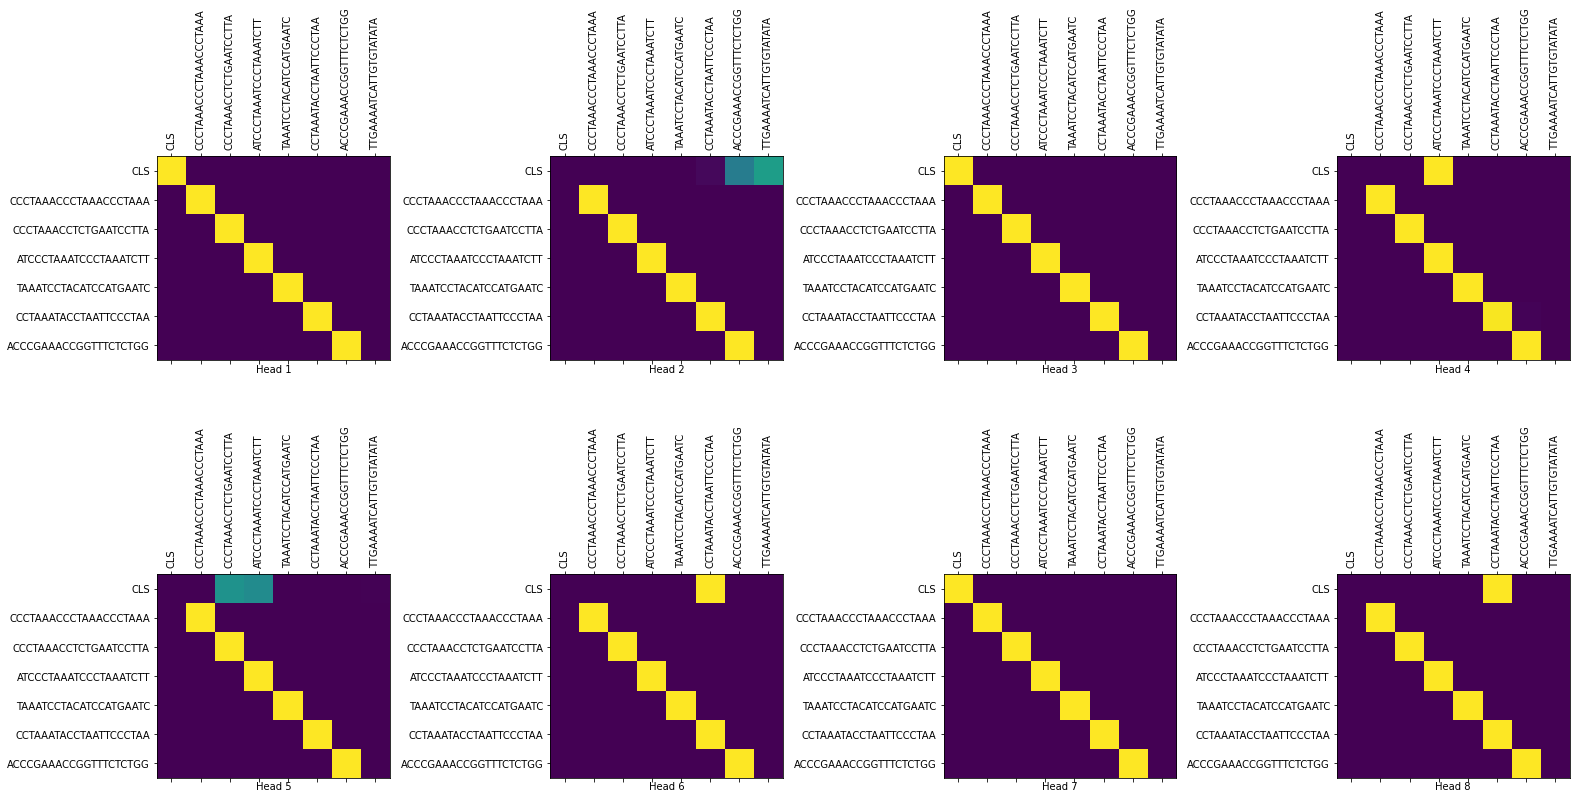

In [81]:
# We can look at the first layer
plot_attention_weights(attn, kmers_converted, "encoder_layer1_block")

# Not much interesting, first layer the kmers only care about themselves (the CLS token looks around a bit) -- Kind of makes sense

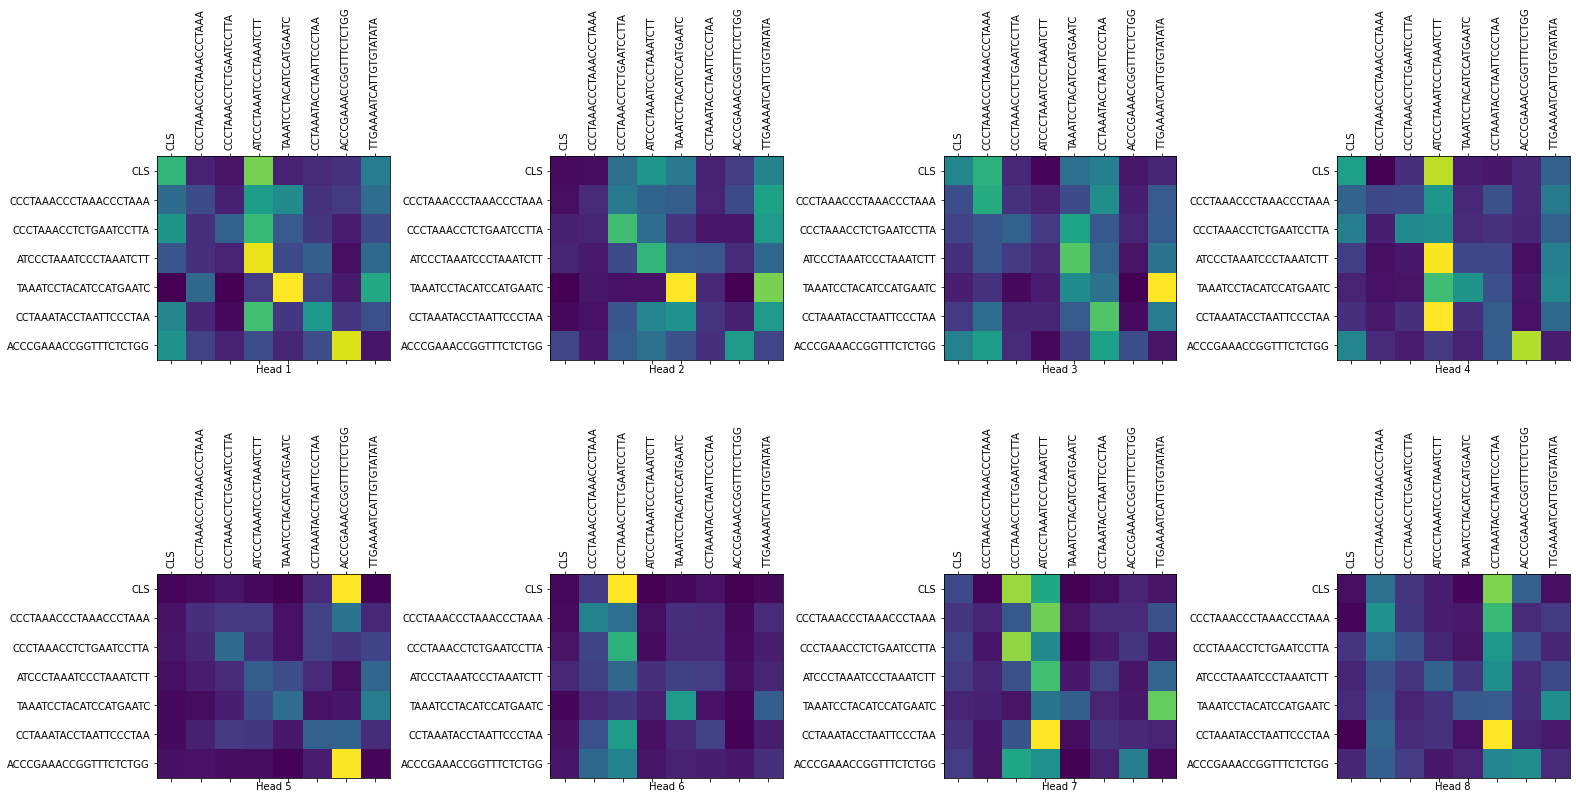

In [82]:
plot_attention_weights(attn, kmers_converted, "encoder_layer2_block")

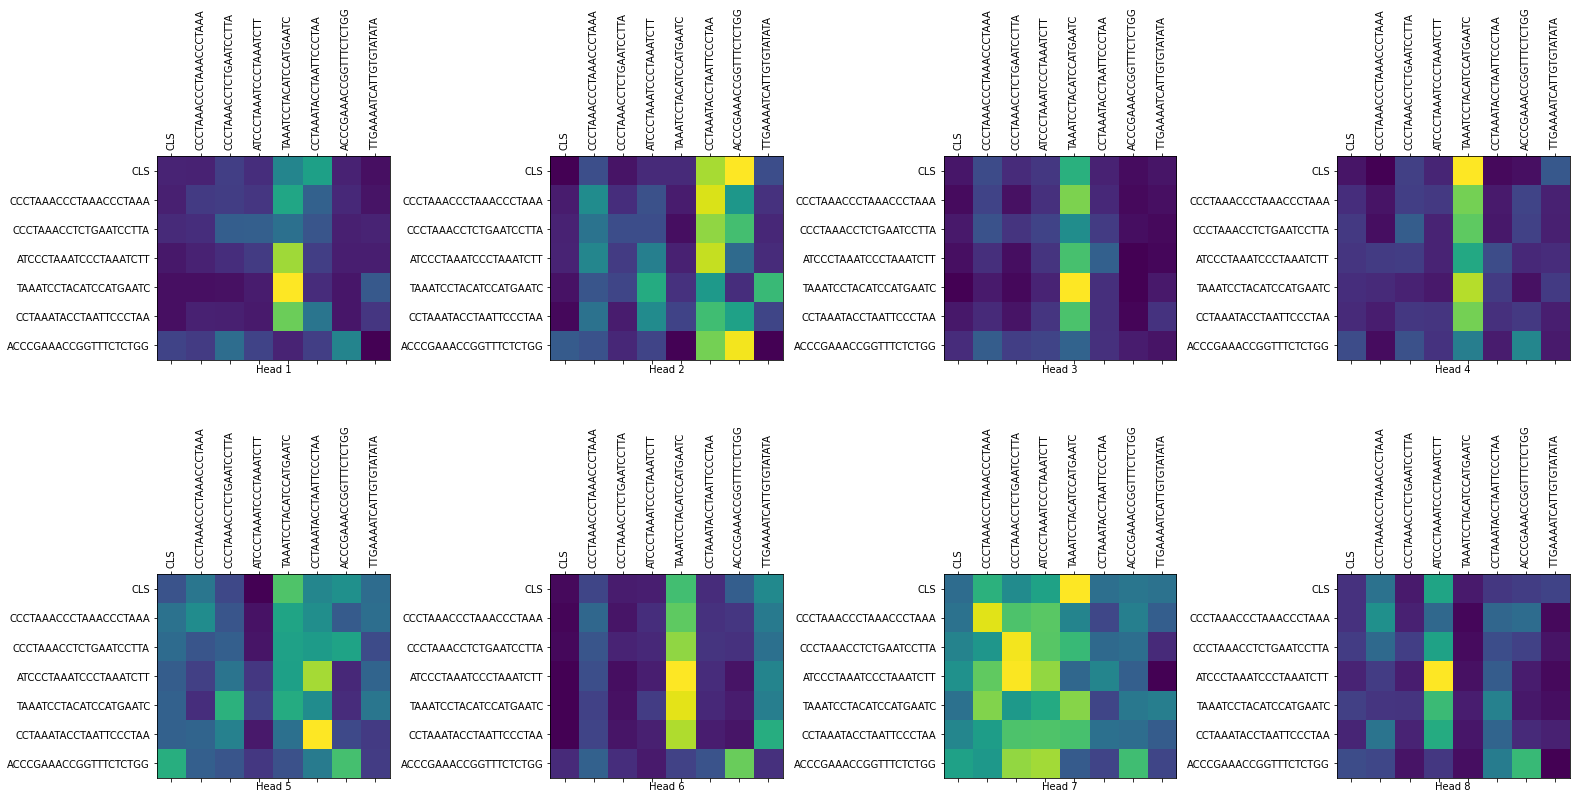

In [83]:
plot_attention_weights(attn, kmers_converted, "encoder_layer3_block")

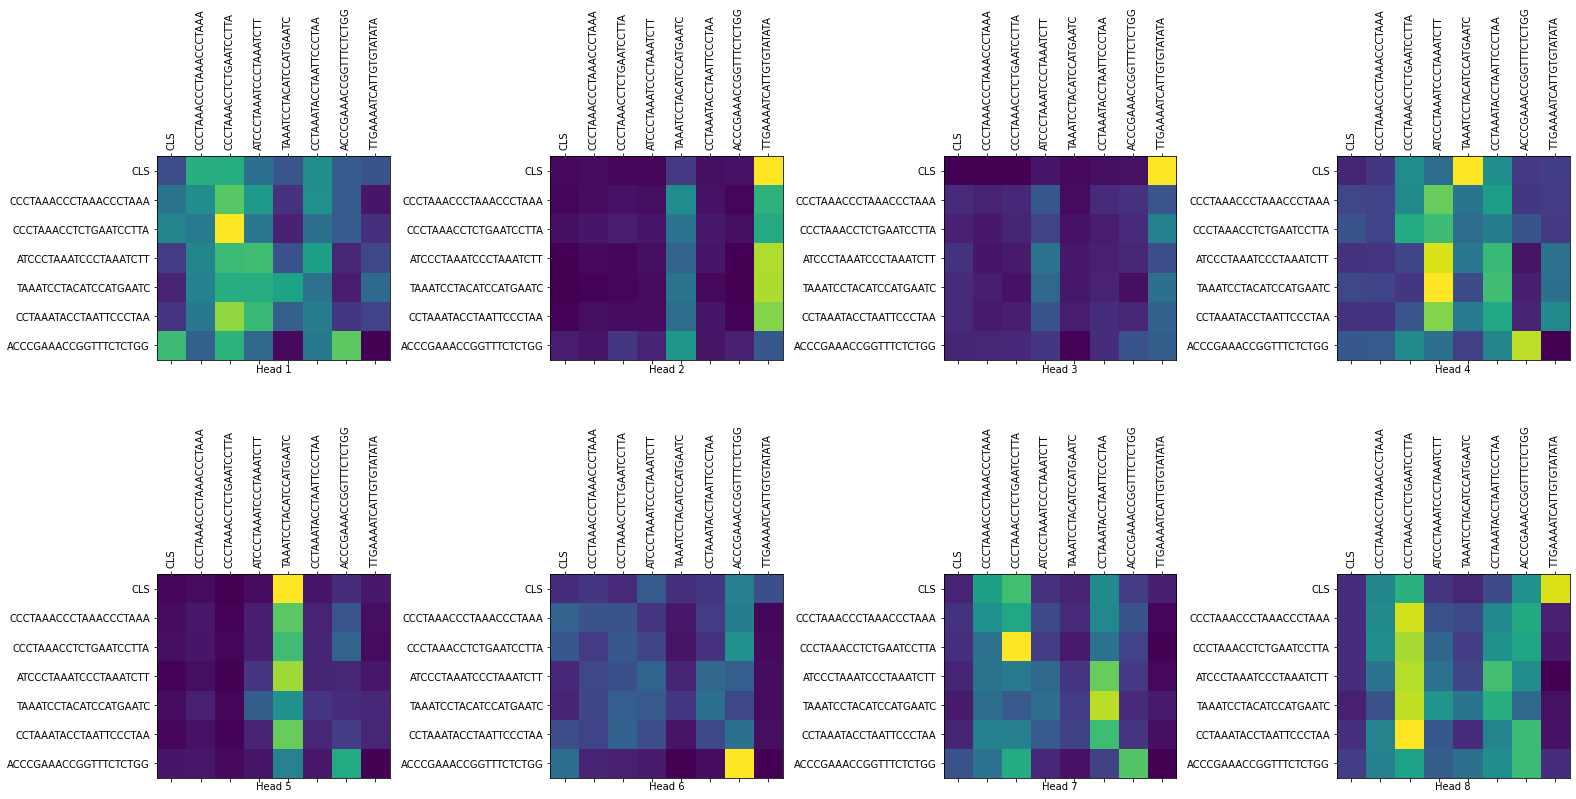

In [84]:
plot_attention_weights(attn, kmers_converted, "encoder_layer4_block")

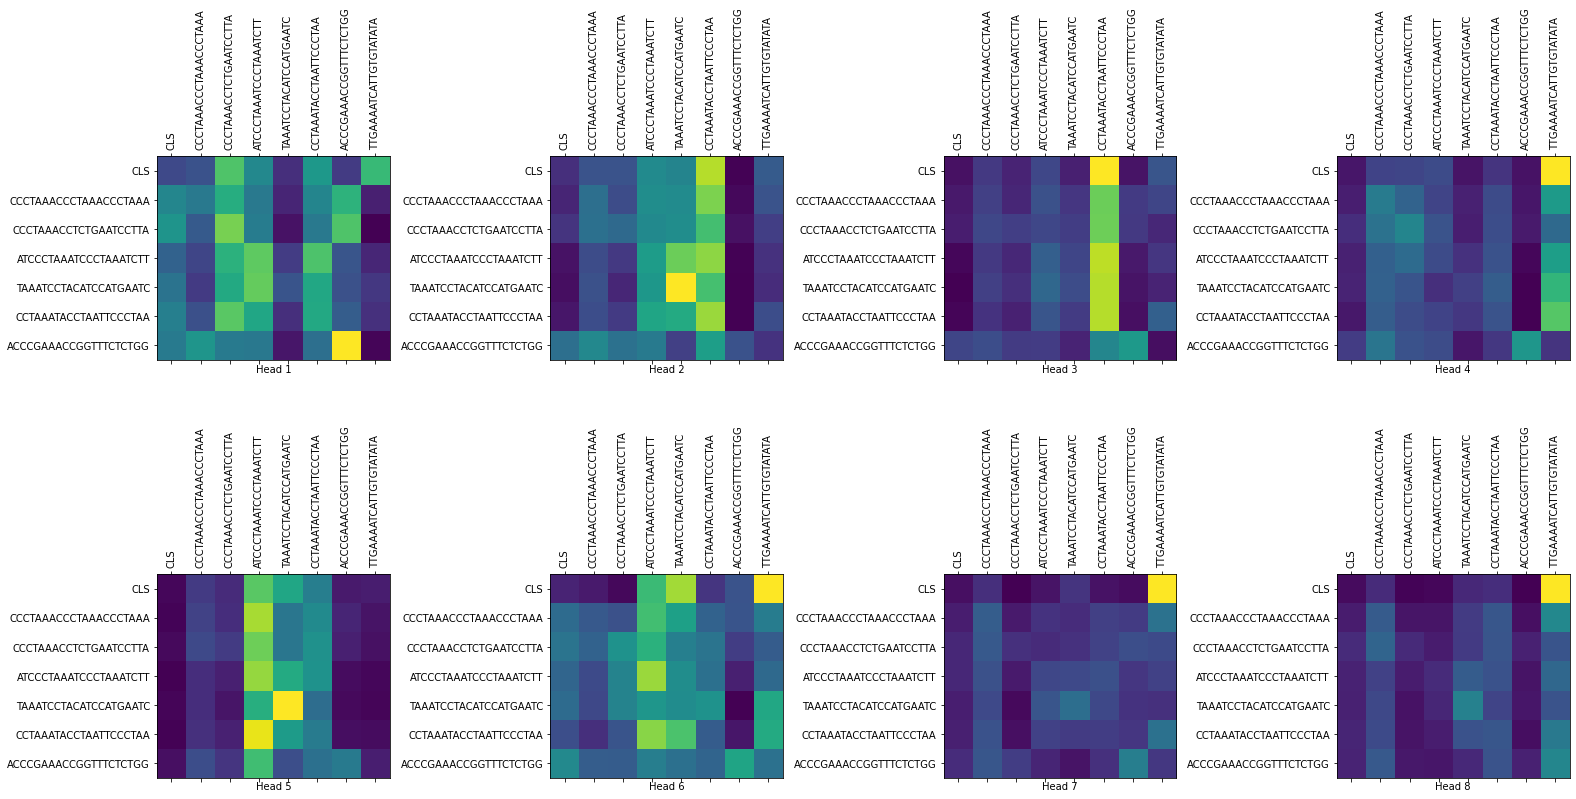

In [85]:
plot_attention_weights(attn, kmers_converted, "encoder_layer5_block")

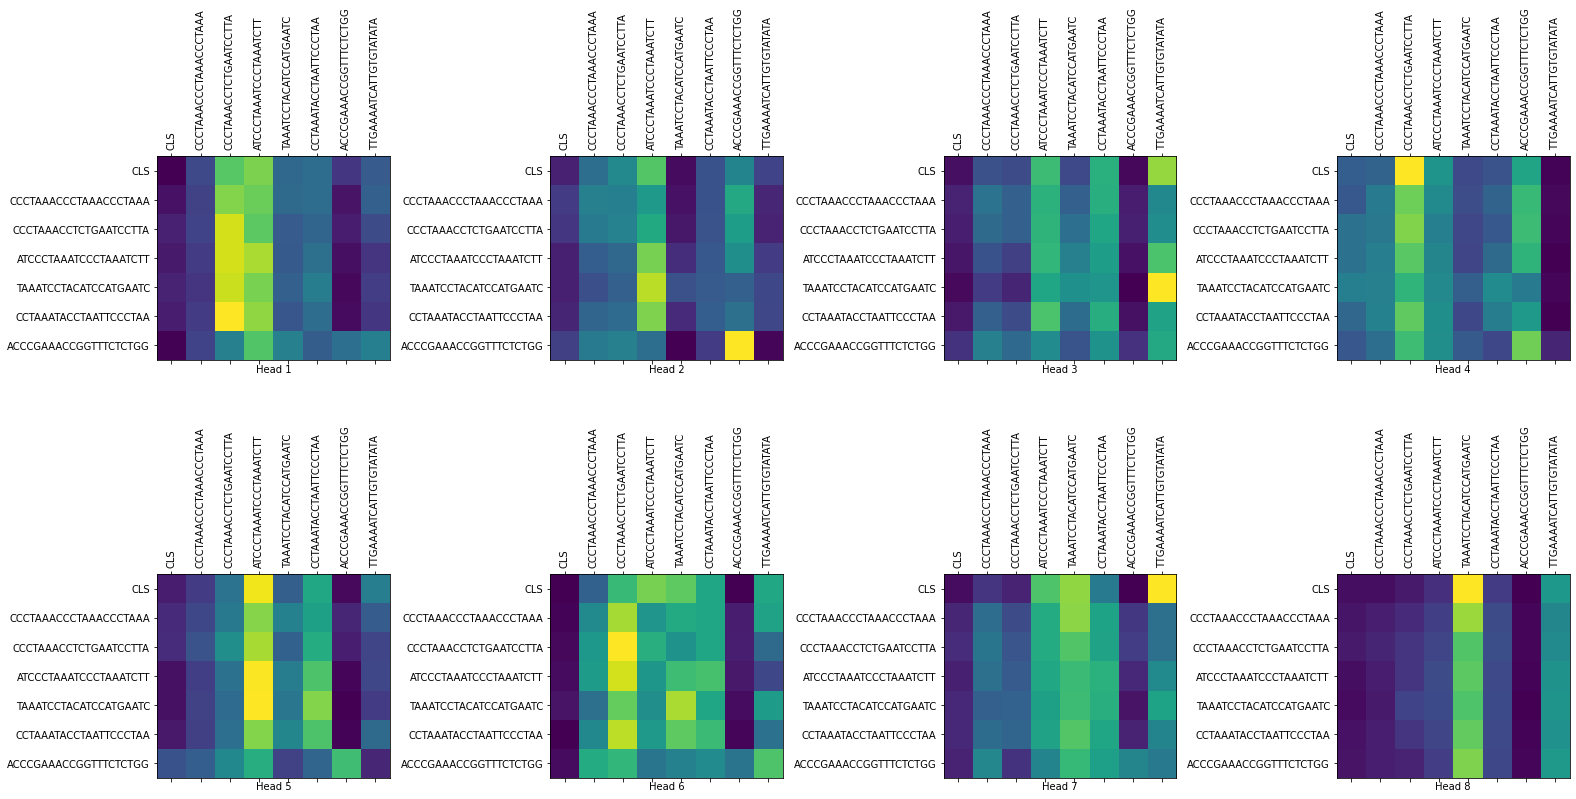

In [86]:
plot_attention_weights(attn, kmers_converted, "encoder_layer6_block")

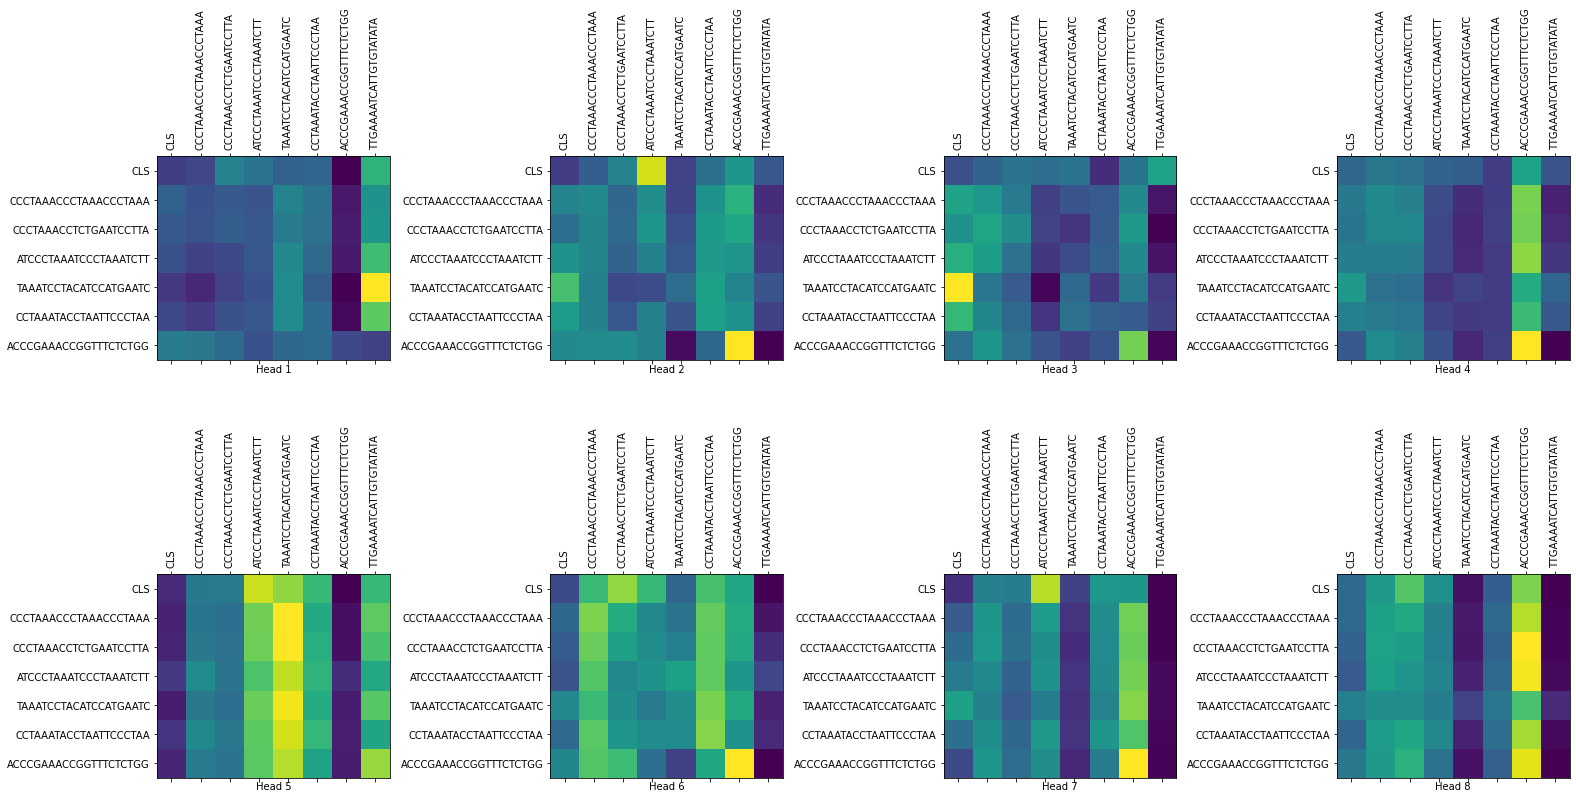

In [87]:
plot_attention_weights(attn, kmers_converted, "encoder_layer7_block")

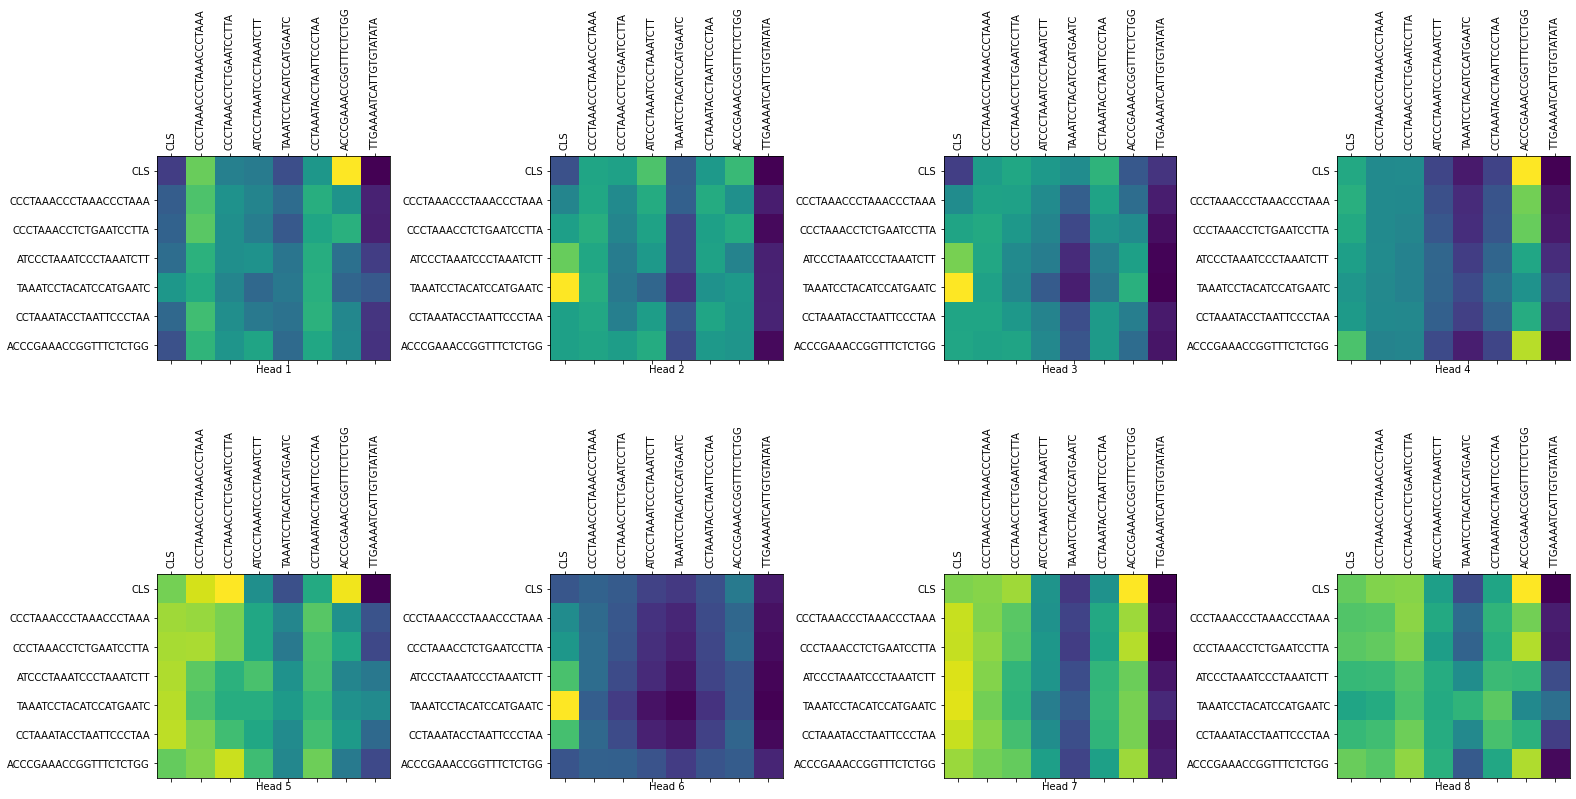

In [88]:
plot_attention_weights(attn, kmers_converted, "encoder_layer8_block")

## Attention with window size of 24

So there's some issues with the first 6 or 7 tokens... as seen below in blocks and patterns. It's hard to see, but it indicates our problem above is likely due to training on a smaller window and then running it on a larger window


In [53]:
window_size = 24
kmerwindowsgen = pyracular.FastaKmersGenerator(k, "Arabidopsis_chr1.sfasta", window_size, False, False)
window = next(kmerwindowsgen)
kmers = np.concatenate([cls, window[0]])
output, attn, all_output = transformer(magic(np.asarray([kmers])))
kmers_converted = ["CLS"]
kmers_converted.extend(convert_all_kmers(window[0]))

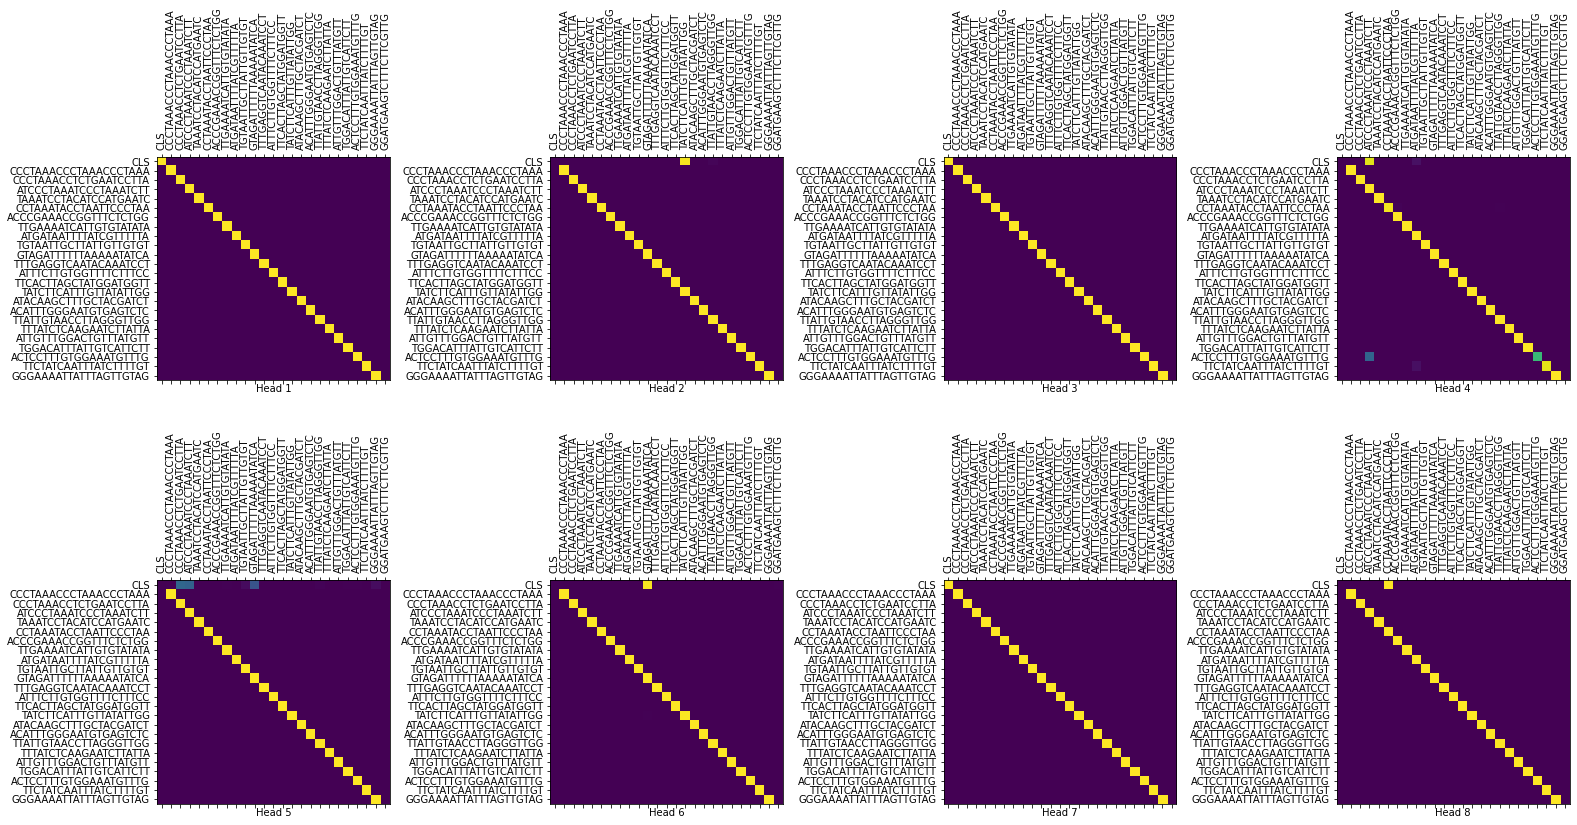

In [55]:
# We can look at the first layer
plot_attention_weights(attn, kmers_converted, "encoder_layer1_block")

# Not much interesting, first layer the kmers only care about themselves (the CLS token looks around a bit) -- Kind of makes sense

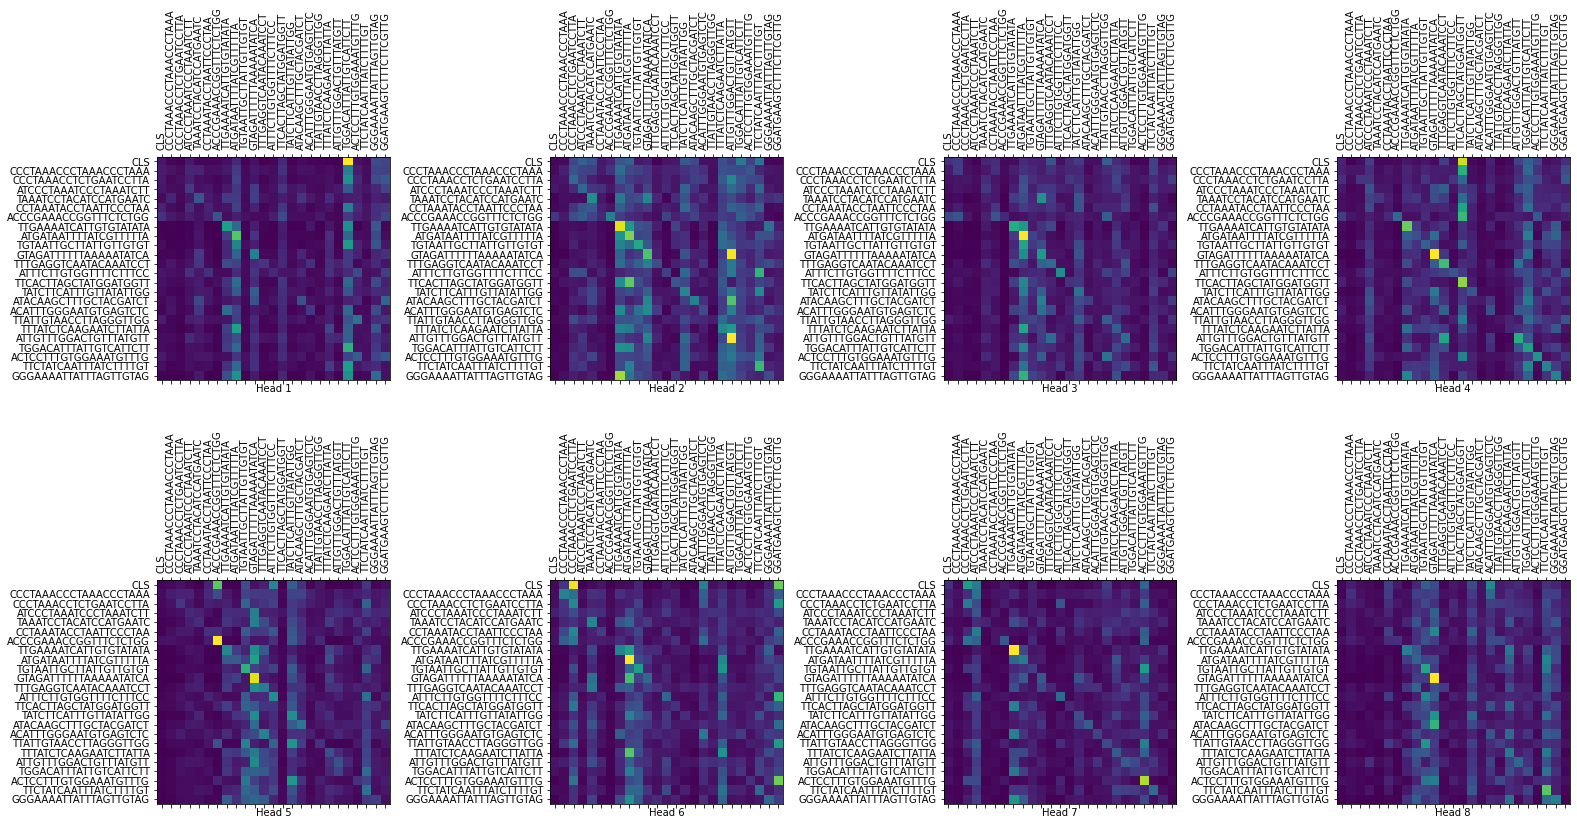

In [56]:
plot_attention_weights(attn, kmers_converted, "encoder_layer2_block")
# Layer 2

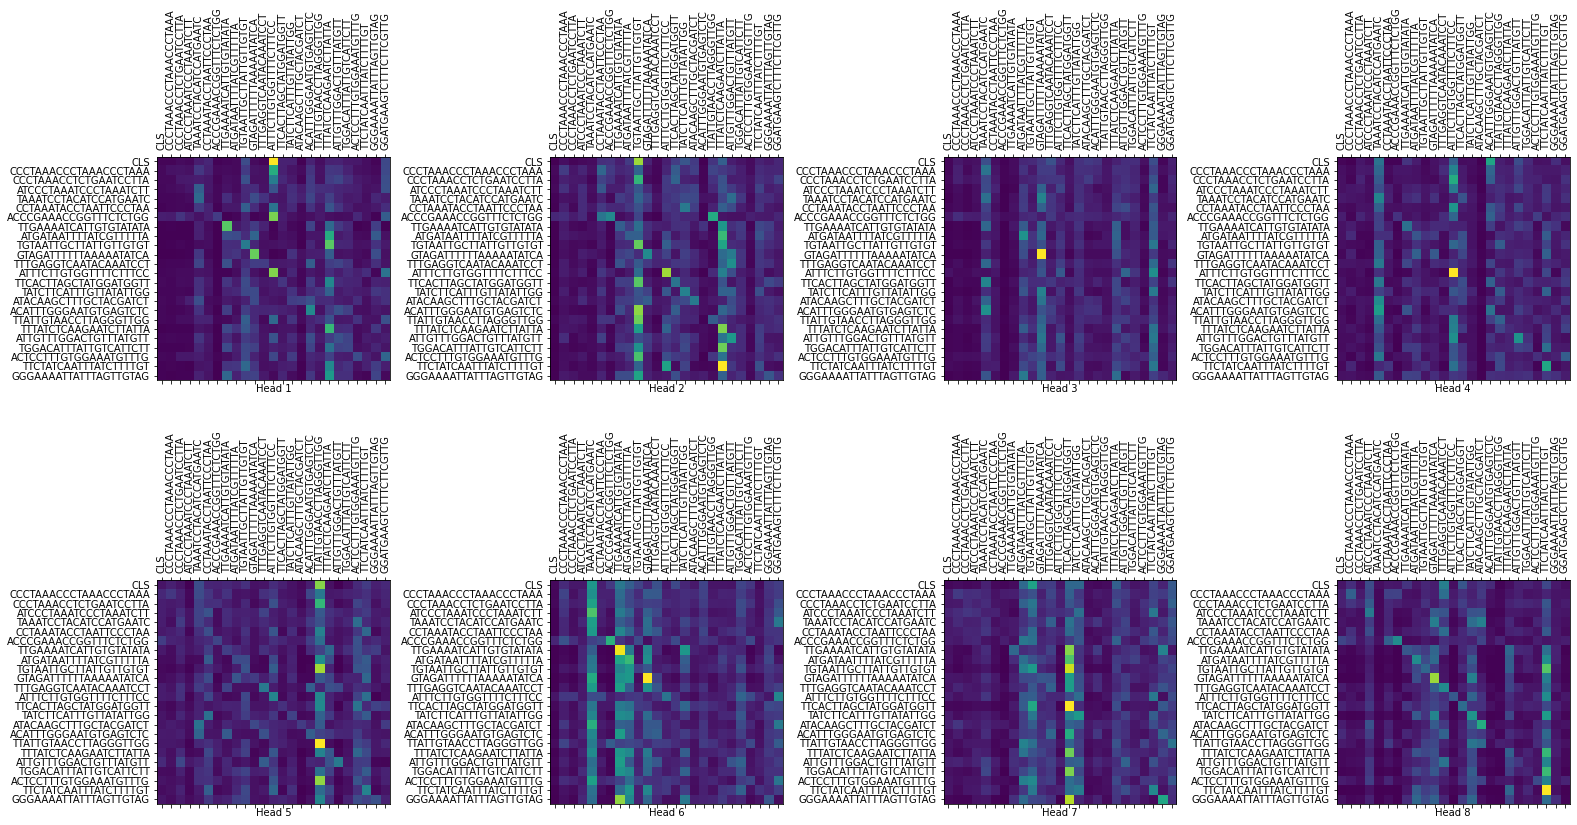

In [57]:
plot_attention_weights(attn, kmers_converted, "encoder_layer3_block")
# Layer 3

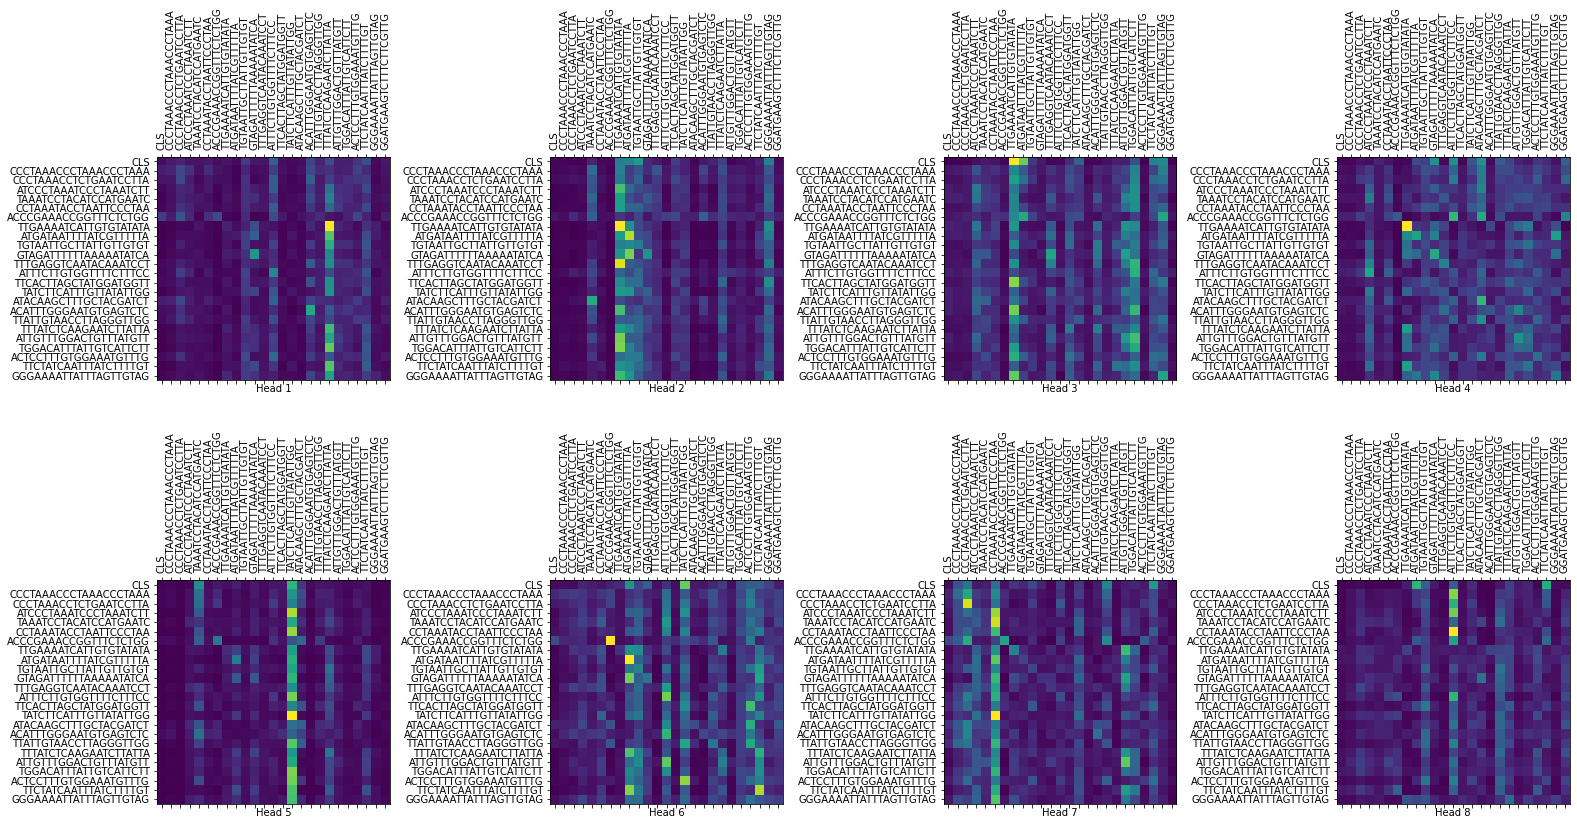

In [58]:
plot_attention_weights(attn, kmers_converted, "encoder_layer4_block")
# Layer 4

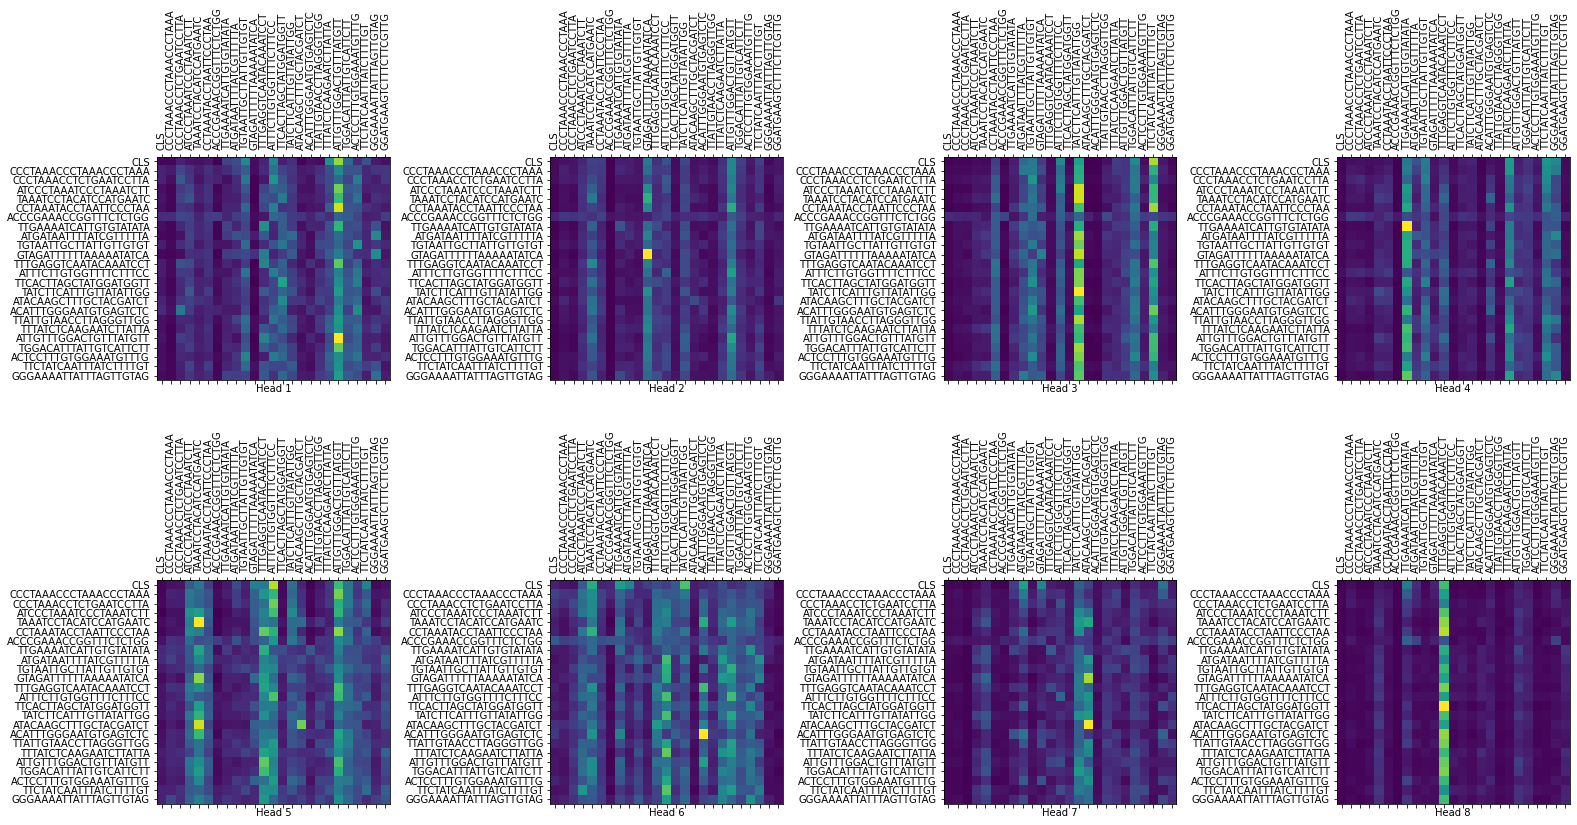

In [59]:
plot_attention_weights(attn, kmers_converted, "encoder_layer5_block")
# Layer 5

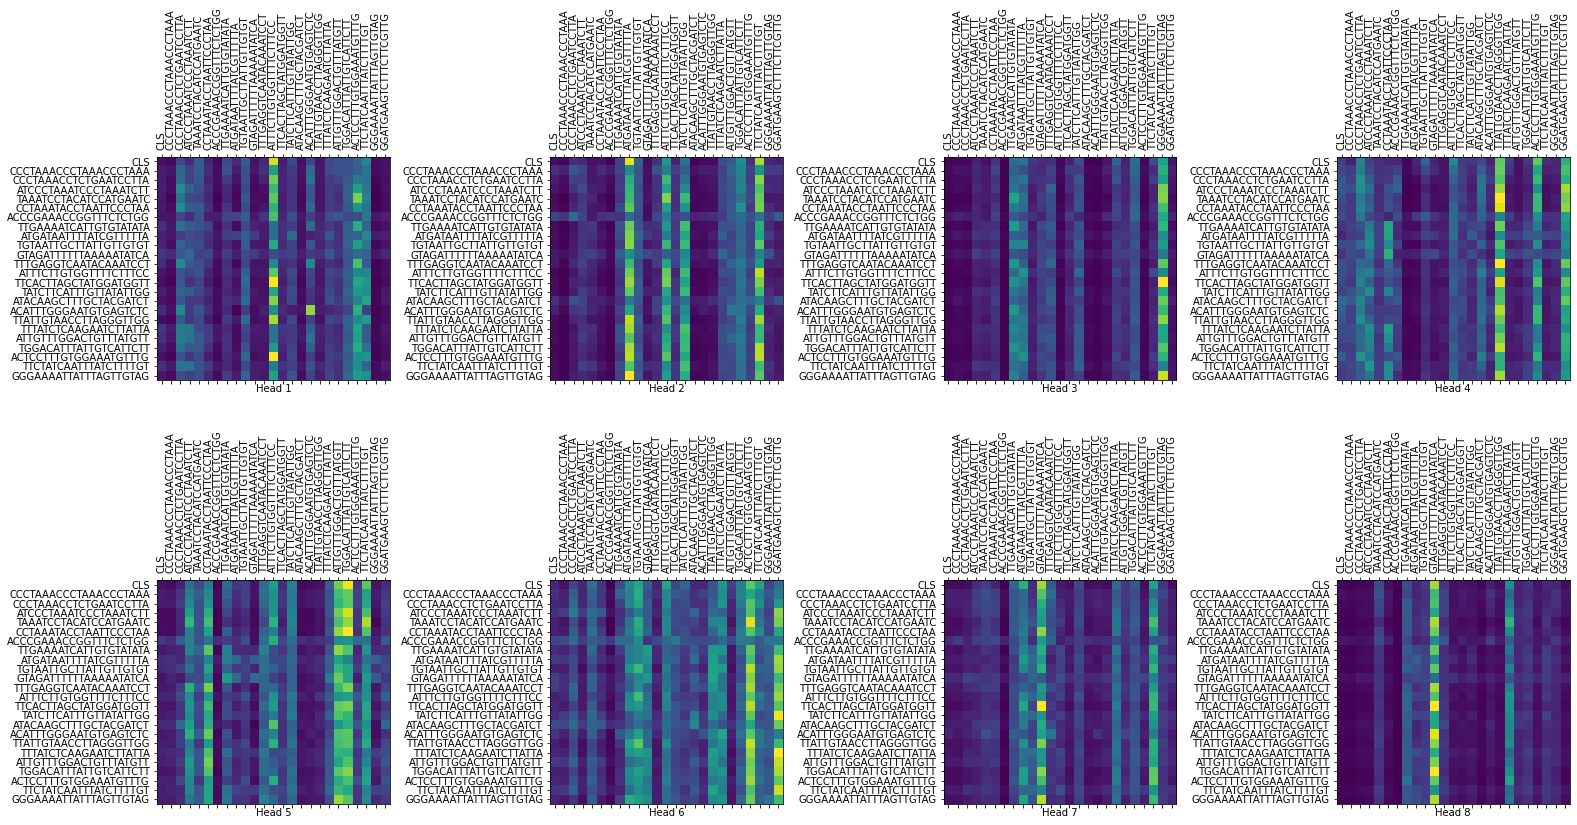

In [60]:
plot_attention_weights(attn, kmers_converted, "encoder_layer6_block")
# Layer 6

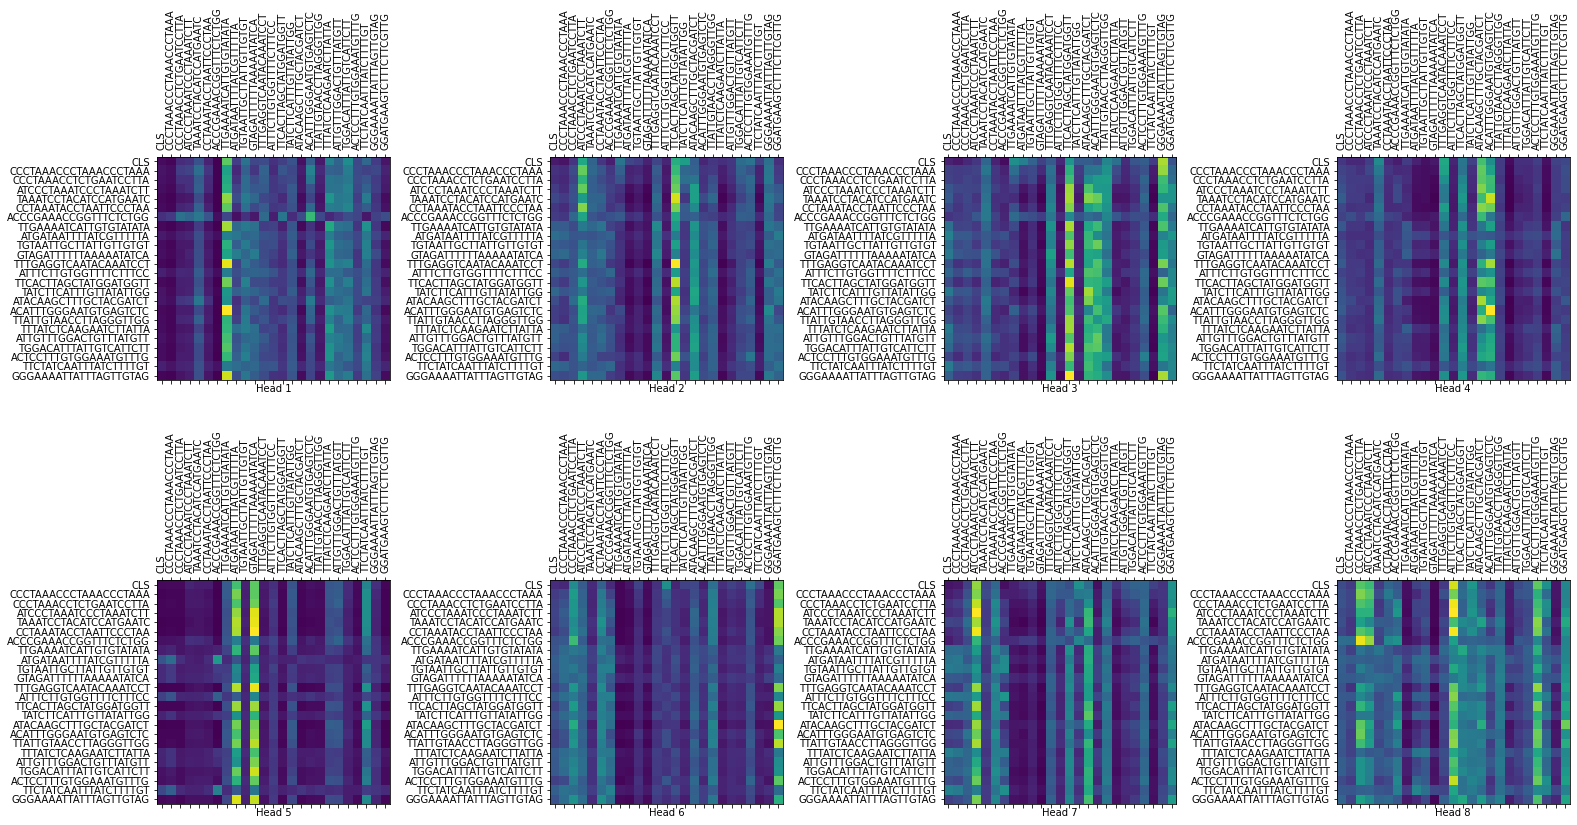

In [61]:
plot_attention_weights(attn, kmers_converted, "encoder_layer7_block")
# Layer 7

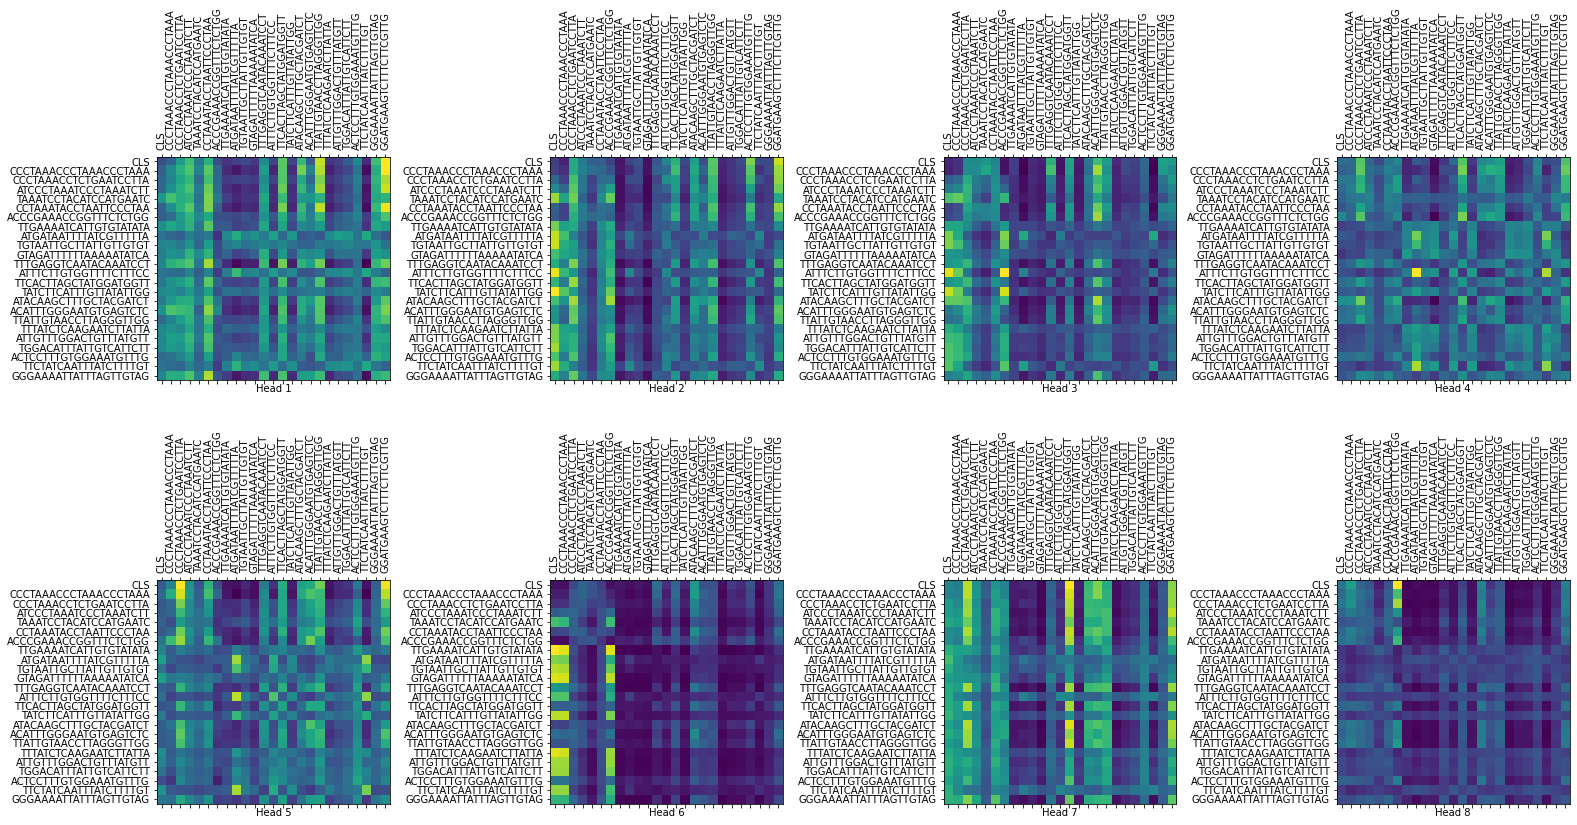

In [62]:
plot_attention_weights(attn, kmers_converted, "encoder_layer8_block")
# Layer 8 (Final Layer)